# Vision por Computadora I - CEIA

## Trabajo Practico N° 3

#### Autor: Juan Ignacio Ribet

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template
1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del ítem 1
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes. Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección.

In [73]:
#%matplotlib qt

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob
import os

## Punto 1

Debido a que el método de 'matchTemplate' es sensible al tamaño del témplate voy a realizar iteraciones en varias escalas para poder detectar el logo en los diferentes tamaños de imágenes y así obtener el valor máximo de coincidencia. Voy a utilizar el metodo 'cv.TM_CCOEFF_NORMED' para las detecciones.

Primero grafico los valores máximos obtenidos en relación con diferentes escalas del témplate para poder fijar un limite del valor maximo de de coincidencia del metodo.

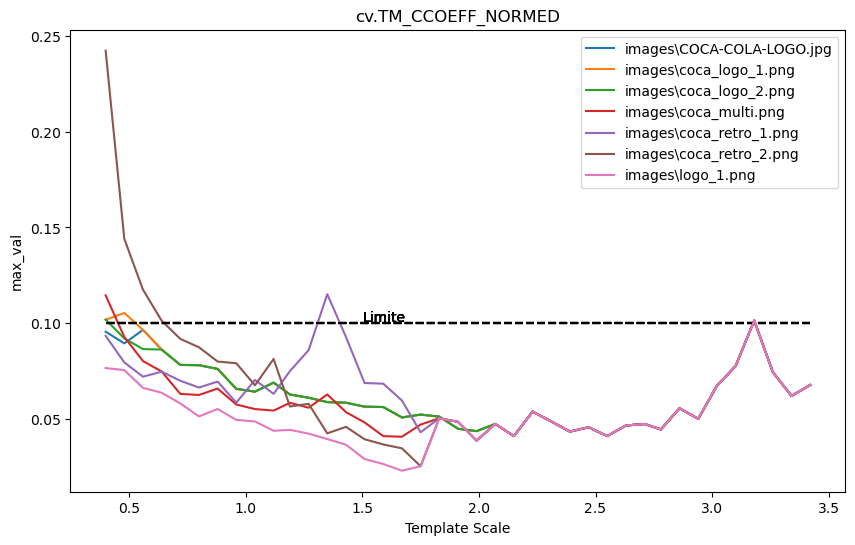

In [74]:
val_list = {}
plt.figure(figsize=(10, 6))

# Bucle por cada imagen.
for imagePath in glob.glob('images/**'):
    # Cargo la imagen y le aplico el preprocesamiento.
    image = cv.imread(imagePath,0)
    edges = cv.Canny(image.copy(), 500,700)

    # Cargo el template y le aplico el preprocesamiento.
    template = cv.imread('template\pattern.png',0)    
    template_edges = cv.Canny(template.copy(), 200,300)
    ht, wt = template.shape

    # Bucle por las escalas.
    for scale in np.linspace(0.4,3.5,40)[::-1]:

        # Modifico el tamaño del template a la escala determinada. 
        temp_res = cv.resize(template_edges.copy(), [int(wt * scale), int(ht * scale)])

        # Verifico que el tamaño del témplate sea menor que la imagen, en caso contrario continua.
        if temp_res.shape[1] > edges.shape[1]:
            continue                
        
        # Aplico la coincidencia de patrones.
        result = cv.matchTemplate(edges.copy(), temp_res.copy(), cv.TM_CCOEFF_NORMED)

        # Encuentro los valores máximos y mínimos.
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)

        # Guardo los valores máximos y las escalas.
        val_list[round(scale,2)] = max_val 

        # Defino en umbral en 0.1
        limite = 0.1
        
    # Graficamos.
    plt.title('cv.TM_CCOEFF_NORMED')
    plt.plot(val_list.keys(), [limite for x in val_list.keys()], ls ='--' , c = 'black')
    plt.plot(val_list.keys(), val_list.values(), label=imagePath)
    plt.xlabel('Template Scale')
    plt.ylabel('max_val')
    plt.annotate('Limite',(1.5,0.101))
    plt.legend()
        

Teniendo el limite de coincidencia realizo la detección en cada imagen iterando en las diferentes escalas.

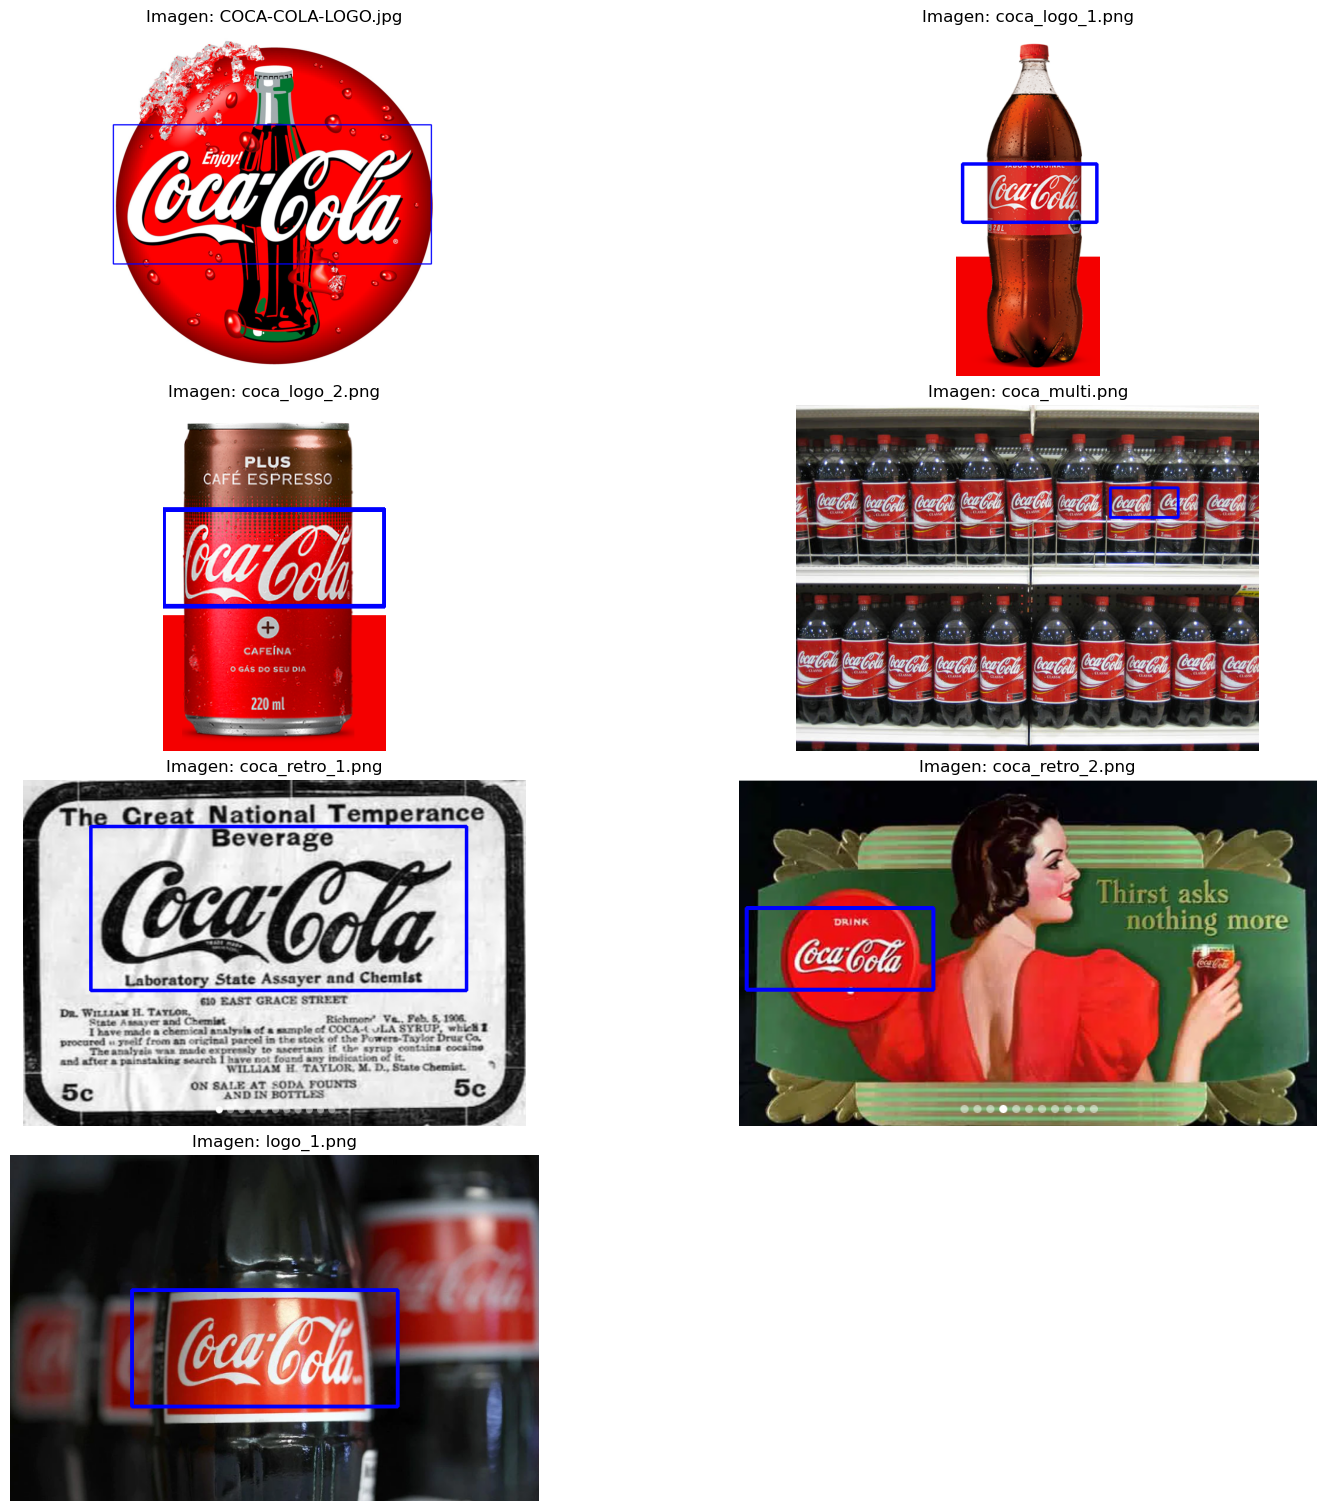

In [75]:
fig, axs = plt.subplots(4, 2, figsize=(15, 15), layout='constrained')

# Bucle por cada imagen
for imagePath, ax in zip(glob.glob('images/**'), axs.flat):

    # Cargo la imagen y le aplico el preprocesamiento.
    image = cv.imread(imagePath)
    img_rgb= cv.cvtColor(image, cv.COLOR_BGR2RGB)
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    edges = cv.Canny(gray.copy(), 400, 550)

    # Cargo el template y le aplico el preprocesamiento.
    template = cv.imread('template\pattern.png',0)
    template_edges = cv.Canny(template.copy(), 350, 500)  
    wt, ht = template.shape

    # Inicializo la lista donde guardo los datos
    val_list = []

    # #Defino las escalas
    # scale_list = np.linspace(0.4,3.5,40)[::-1]
    
    #Defino las escalas según el tamaño de las imágenes para reducir la cantidad de iteraciones.
    scale_list = np.linspace(0.2,2,20)[::-1]
    if image.shape[1] > (2*template.shape[1]):
        scale_list = np.linspace(1.5,3.5,20)[::-1]

    # Bucle por las escalas determinadas
    for scale in scale_list:

        # Modifico el tamaño del template a la escala determinada. 
        temp_res_heigth = int(ht * scale)
        temp_res_width = int(wt * scale)
        temp_res = cv.resize(template_edges.copy(), [temp_res_heigth, temp_res_width])
        
        # Verifico que el tamaño del témplate sea menor que la imagen, en caso contrario continua.
        if temp_res.shape[1] > edges.shape[1]:
            continue

        # Aplico la coincidencia de patrones.
        result = cv.matchTemplate(edges, temp_res, cv.TM_CCOEFF_NORMED)

        # Encuentro los valores máximos.
        _, max_val, _, max_loc = cv.minMaxLoc(result)

        # Guardo los valores máximos, la ubicación y el tamaño del template.
        val_list.append([max_val, max_loc, temp_res_width, temp_res_heigth])

        #Fijo el umbral donde se detiene el bucle
        if max_val > limite:
            break

    # Obtengo el valor máximo de todas las escalas.
    max_value = max([val_list[x][0] for x in range(len(val_list))])
    index = [x for x in range(len(val_list)) if val_list[x][0] == max_value]
    top_left = val_list[index[0]][1]

    # Marco el lugar donde haya encontrado el valor máximo y vizualizo en la imagen original.
    bottom_right = (top_left[0] + val_list[index[0]][3], top_left[1] + val_list[index[0]][2])
    cv.rectangle(img_rgb,top_left, bottom_right, (0,0,255), 3)
    ax.set_title(f'Imagen: {os.path.basename(imagePath)}')
    ax.axis('off')
    ax.imshow(img_rgb)

for ax in axs.flat[len(glob.glob('images/**')):]:
    ax.remove()


## Punto 2

De la misma manera que el punto 1 primero determino el valor de escala óptimo para la detección de logo y luego fijo un umbral de "coincidencia" para las múltiples detecciones.

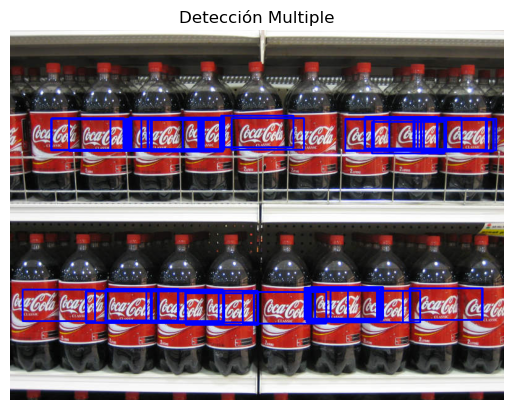

In [76]:
# Cargo la imagen y le aplico el preprocesamiento.
image = cv.imread('images\coca_multi.png')
img_rgb= cv.cvtColor(image, cv.COLOR_BGR2RGB)
gray = cv.cvtColor(image.copy(), cv.COLOR_BGR2GRAY)
edges = cv.Canny(gray.copy(), 400, 550)

# Cargo el template y le aplico el preprocesamiento.
template = cv.imread('template\pattern.png',0)    
template_edges = cv.Canny(template.copy(), 350, 500)
wt, ht = template.shape

# Inicializo la lista donde guardo los datos
val_list = []

#Defino las escalas
scale_list = np.linspace(0.2,2,20)[::-1]

#Bucle por las escalas determinadas
for scale in scale_list:
    
    # Modifico el tamaño del template a la escala determinada.    
    temp_res_heigth = int(ht * scale)
    temp_res_width = int(wt * scale)
    temp_res = cv.resize(template_edges.copy(), [temp_res_heigth, temp_res_width])

    # Verifico que el tamaño del témplate sea menor que la imagen, en caso contrario continua.
    if temp_res.shape[1] > edges.shape[1]:
        continue
    
    # Aplicamos la coincidencia de patrones.
    result = cv.matchTemplate(edges, temp_res, cv.TM_CCOEFF_NORMED)

    # Encontramos los valores máximos.
    _, max_val, _, _ = cv.minMaxLoc(result)

    # Guardamos los valores máximo y la escala.
    val_list.append([max_val, scale])
    if max_val > limite:
     break

# Obtengo la escala para la cual se obtuvo el valor máximo.
max_value = max([val_list[x][0] for x in range(len(val_list))])
x = [x for x in range(len(val_list)) if val_list[x][0] == max_value]
scale_op = val_list[x[0]][1]

#Aplico los patrones de coincidencia a la escala obtenida.
temp_res_heigth = int(ht * scale_op)
temp_res_width = int(wt * scale_op)
temp_res = cv.resize(template_edges.copy(), [temp_res_heigth, temp_res_width])
result = cv.matchTemplate(edges, temp_res, cv.TM_CCOEFF_NORMED)

# Fijo un umbral de "coincidencia".
threshold = 0.11
boxes_p2 = []
loc = np.where( result > threshold)
for pt in zip(*loc[::-1]):
    cv.rectangle(img_rgb, pt, (pt[0]+temp_res_heigth , pt[1]+temp_res_width), (0,0,255), 2)
    boxes_p2.append([pt[0],pt[1] , pt[0]+temp_res_heigth , pt[1]+temp_res_width])
boxes_p2 = np.array(boxes_p2)

# Imagen original con recuadro.
plt.figure()
plt.imshow(img_rgb)
plt.title('Detección Multiple'); plt.axis('off')
plt.show()

## Punto 3

Para este punto determino un nivel de confianza de 85% y fijo un umbral de "coincidencia" en relación a ese nivel.

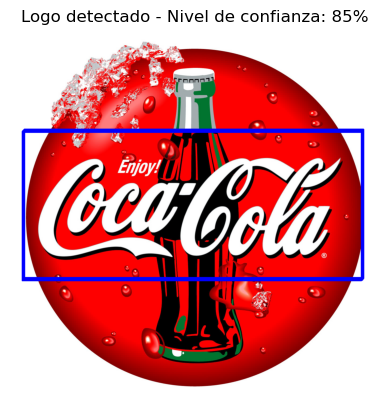

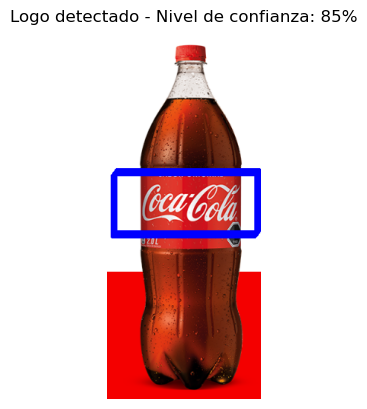

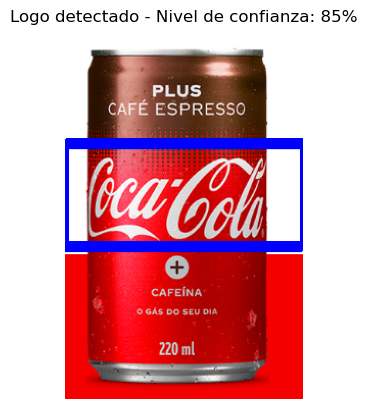

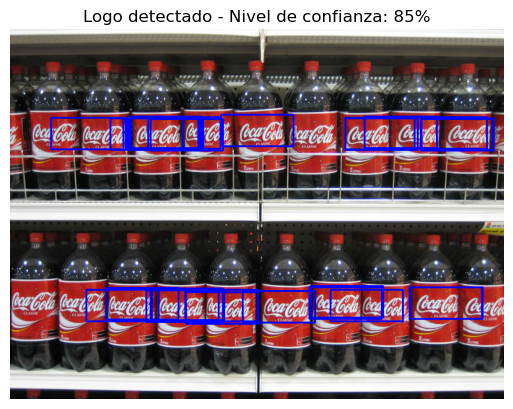

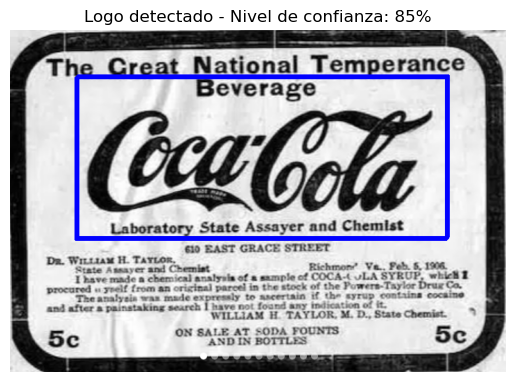

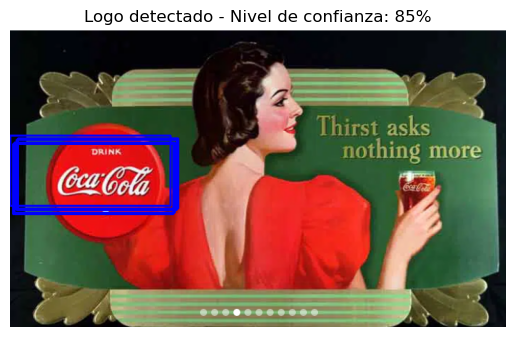

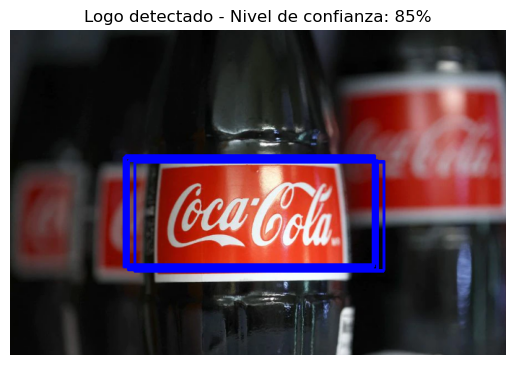

In [77]:
# Bucle por cada imagen
for imagePath in glob.glob('images/**'):    
# Cargo las imagen y le aplico el preprocesamiento.
    image = cv.imread(imagePath)
    img_rgb= cv.cvtColor(image, cv.COLOR_BGR2RGB)
    gray = cv.cvtColor(image.copy(), cv.COLOR_BGR2GRAY)
    edges = cv.Canny(gray.copy(), 400, 550)
    # Cargo el template y le aplico el preprocesamiento.
    template = cv.imread('template\pattern.png',0)    
    template_edges = cv.Canny(template.copy(), 350, 500)
    wt, ht = template.shape

    # Inicializo la lista donde guardo los datos
    val_list = [] 
    
    #Defino las escalas según el tamaño de las imágenes para reducir la cantidad de iteraciones.
    scale_list = np.linspace(0.2,2,20)[::-1]
    if image.shape[1] > (2*template.shape[1]):
        scale_list = np.linspace(1.5,3.5,20)[::-1]

    # Bucle por las escalas determinadas.
    for scale in scale_list:

        # Modifico el tamaño del template a la escala determinada.   
        temp_res_heigth = int(ht * scale)
        temp_res_width = int(wt * scale)
        temp_res = cv.resize(template_edges.copy(), [temp_res_heigth, temp_res_width])

        # Verifico que el tamaño del témplate sea menor que la imagen, en caso contrario continua.
        if temp_res.shape[1] > edges.shape[1]:
            continue

        # Aplico la coincidencia de patrones.
        result = cv.matchTemplate(edges, temp_res, cv.TM_CCOEFF_NORMED)

        # Encontramos los valores máximos y mínimos.
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)

        # Guardamos los valores máximo y la escala.
        val_list.append([max_val, scale])

        #Fijo el umbral donde se detiene el bucle
        if max_val > limite:
            break

    # Obtengo la escala para la cual se obtuvo el valor maximo.
    max_value = max([val_list[x][0] for x in range(len(val_list))])
    x = [x for x in range(len(val_list)) if val_list[x][0] == max_value]
    scale_op = val_list[x[0]][1]

    # Aplico los patrones de coincidencia a la escala obtenida.
    temp_res_heigth = int(ht * scale_op)
    temp_res_width = int(wt * scale_op)
    temp_res = cv.resize(template_edges.copy(), [temp_res_heigth, temp_res_width])
    result = cv.matchTemplate(edges, temp_res, cv.TM_CCOEFF_NORMED)

    # Determino el nivel de confianza de la detección del 85%.
    NCD = 0.85

    # Fijo un umbral de "coincidencia" en relación al NCD.
    threshold = max_value*NCD
    boxes_p3= []
    loc = np.where( result > threshold)
    for pt in zip(*loc[::-1]):
        cv.rectangle(img_rgb, pt, (pt[0]+temp_res_heigth , pt[1]+temp_res_width), (0,0,255), 2)

    # Imagen original con recuadro.
    plt.figure()
    plt.imshow(img_rgb)
    plt.title(f'Logo detectado - Nivel de confianza: {NCD:.0%}'); plt.axis('off')
    plt.show()

Para los puntos 2 y 3 utilizo el codigo de Non max suppression obtenido de: https://pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/

In [78]:
#https://pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
	# initialize the list of picked indexes	
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")

Aplico NMS para el punto 2

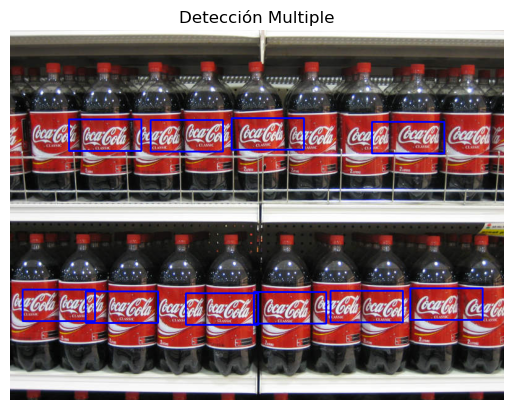

In [79]:
image = cv.imread('images\coca_multi.png')
img_rgb= cv.cvtColor(image, cv.COLOR_BGR2RGB)

boxes_pick = non_max_suppression_fast(boxes_p2, 0.2)

for bx in boxes_pick:
   cv.rectangle(img_rgb, (bx[0], bx[1]), (bx[2],bx[3]), (0,0,255), 2)

# Imagen original con recuadro.
plt.figure()
plt.imshow(img_rgb)
plt.title('Detección Multiple'); plt.axis('off')
plt.show()

Aplico NMS para el punto 3

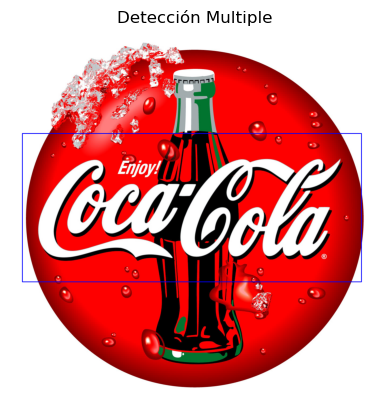

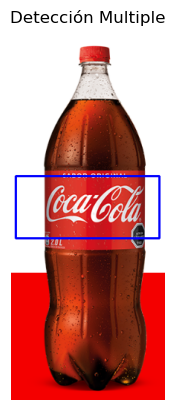

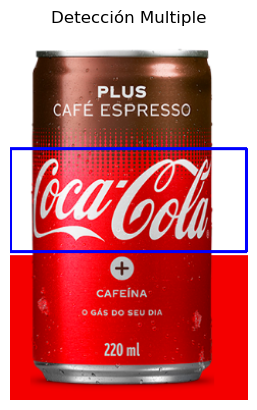

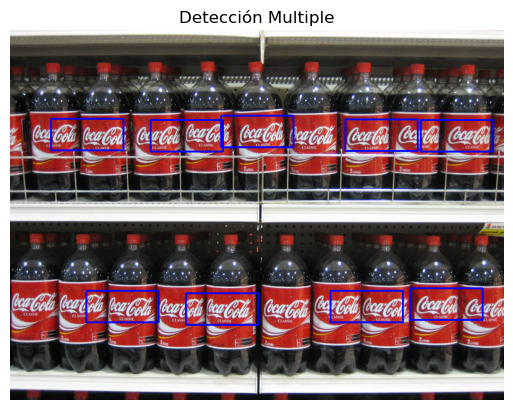

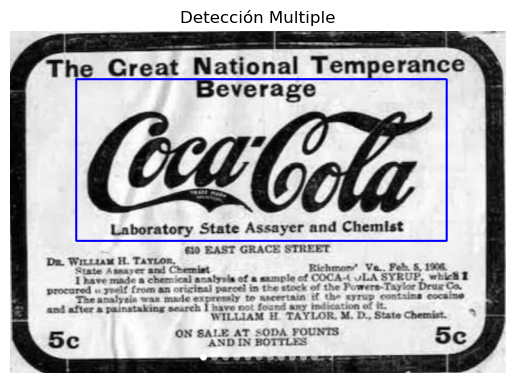

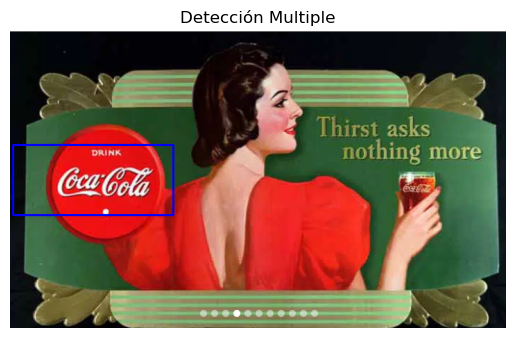

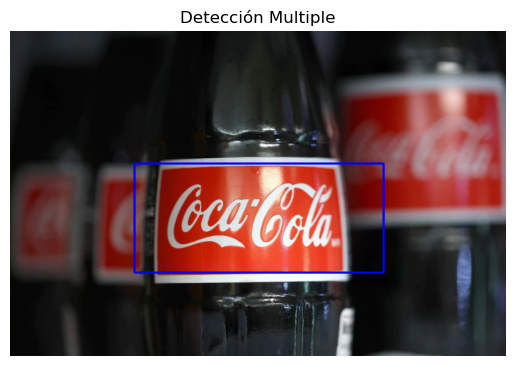

In [82]:
# Bucle por cada imagen
for imagePath in glob.glob('images/**'):    
# Cargo las imagen y le aplico el preprocesamiento.
    image = cv.imread(imagePath)
    img_rgb= cv.cvtColor(image, cv.COLOR_BGR2RGB)
    gray = cv.cvtColor(image.copy(), cv.COLOR_BGR2GRAY)
    edges = cv.Canny(gray.copy(), 400, 550)
    # Cargo el template y le aplico el preprocesamiento.
    template = cv.imread('template\pattern.png',0)    
    template_edges = cv.Canny(template.copy(), 350, 500)
    wt, ht = template.shape

    # Inicializo la lista donde guardo los datos
    val_list = [] 
    
    #Defino las escalas según el tamaño de las imágenes para reducir la cantidad de iteraciones.
    scale_list = np.linspace(0.2,2,20)[::-1]
    if image.shape[1] > (2*template.shape[1]):
        scale_list = np.linspace(1.5,3.5,20)[::-1]

    # Bucle por las escalas determinadas.
    for scale in scale_list:

        # Modifico el tamaño del template a la escala determinada.   
        temp_res_heigth = int(ht * scale)
        temp_res_width = int(wt * scale)
        temp_res = cv.resize(template_edges.copy(), [temp_res_heigth, temp_res_width])

        # Verifico que el tamaño del témplate sea menor que la imagen, en caso contrario continua.
        if temp_res.shape[1] > edges.shape[1]:
            continue

        # Aplico la coincidencia de patrones.
        result = cv.matchTemplate(edges, temp_res, cv.TM_CCOEFF_NORMED)

        # Encontramos los valores máximos y mínimos.
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)

        # Guardamos los valores máximo y la escala.
        val_list.append([max_val, scale])

        #Fijo el umbral donde se detiene el bucle
        if max_val > limite:
            break

    # Obtengo la escala para la cual se obtuvo el valor maximo.
    max_value = max([val_list[x][0] for x in range(len(val_list))])
    x = [x for x in range(len(val_list)) if val_list[x][0] == max_value]
    scale_op = val_list[x[0]][1]

    # Aplico los patrones de coincidencia a la escala obtenida.
    temp_res_heigth = int(ht * scale_op)
    temp_res_width = int(wt * scale_op)
    temp_res = cv.resize(template_edges.copy(), [temp_res_heigth, temp_res_width])
    result = cv.matchTemplate(edges, temp_res, cv.TM_CCOEFF_NORMED)

    # Determino el nivel de confianza de la detección del 85%.
    NCD = 0.85

    # Fijo un umbral de "coincidencia" en relación al NCD.
    threshold = max_value*NCD
    boxes= []
    loc = np.where( result > threshold)
    for pt in zip(*loc[::-1]):
        #cv.rectangle(img_rgb, pt, (pt[0]+temp_res_heigth , pt[1]+temp_res_width), (0,0,255), 2)
        boxes.append([pt[0],pt[1] , pt[0]+temp_res_heigth , pt[1]+temp_res_width])
    boxes = np.array(boxes)
    boxes_pick = non_max_suppression_slow(boxes, 0.2)

    for bx in boxes_pick:
        cv.rectangle(img_rgb, (bx[0], bx[1]), (bx[2],bx[3]), (0,0,255), 2)

    # Imagen original con recuadro.
    plt.figure()
    plt.imshow(img_rgb)
    plt.title('Detección Multiple'); plt.axis('off')
    plt.show()